In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
# Inspect data
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [5]:
# sort login times, ascending
logins = logins.sort_values('login_time').reset_index().iloc[:, 1]

In [6]:
# make a counts column to keep track of login instances
logins = pd.DataFrame(logins).set_index('login_time')
logins['count'] = 1

# Aggregate number of logins on 15min intervals
logins_15min = logins.resample('15T').sum()
logins_15min

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [7]:
logins_15min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


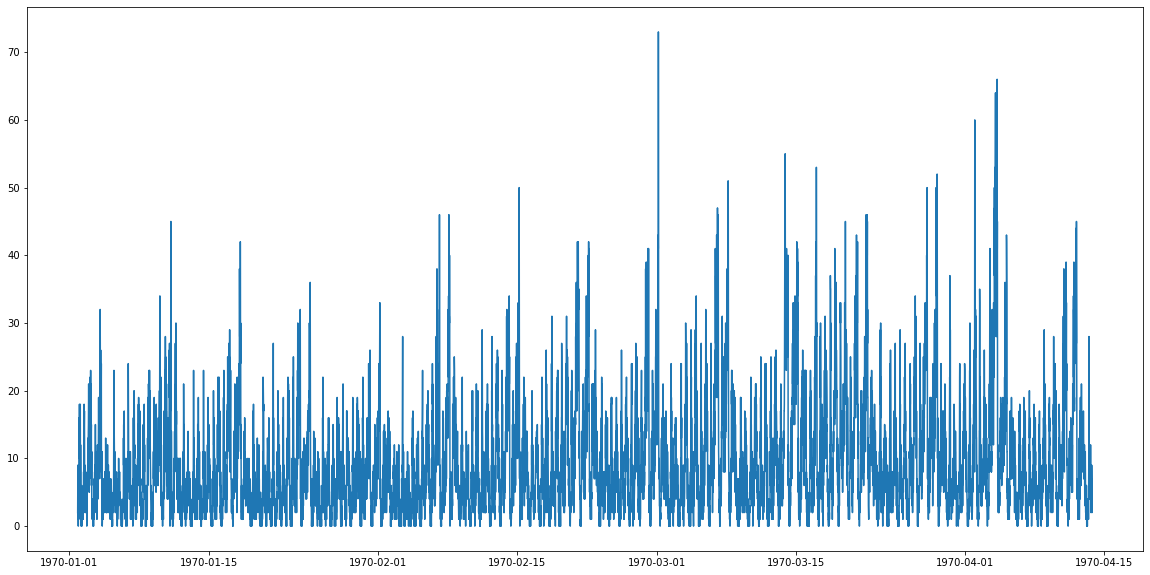

In [8]:
# Plot logins of 15min intervals
plt.figure(figsize=(20,10))
plt.plot(logins_15min.index, logins_15min)
plt.show()

This graph isn't very useful. We can see that there is some cyclical action happening but it is way too condensed to see things clearly. Lets try increasing the time frame of our login sums. 

In [9]:
# # Aggregate number of logins on daily intervals
logins_per_day = logins.resample('1D').sum()
logins_per_day

,count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459
...,...
1970-04-09,818
1970-04-10,1009
1970-04-11,1352


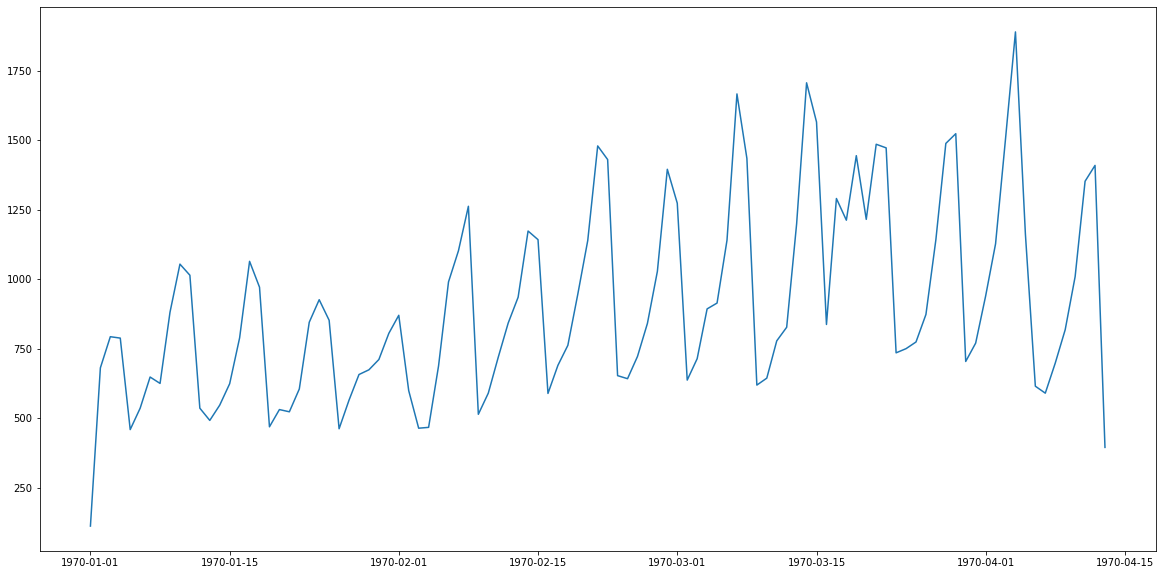

In [10]:
# Plot daily login sums
plt.figure(figsize=(20,10))
plt.plot(logins_per_day.index, logins_per_day['count'])
plt.show()

Here we can the cyclical nature much more clearly. But it still doesn't really tell us that much about the specific times the peaks and troughs are occuring. However, there does seem to be a slight upward trend of logins further down the whole range of time in our data. Lets see if we can see a broader trend over the whole span of the time given

In [11]:
# Get rolling sums on a weekly interval using the daily sums
logins_per_day['smooth'] = logins_per_day['count'].rolling(7).sum()

In [12]:
# Plot the weekly rolling sums
fig = px.line(data_frame = logins_per_day, x = logins_per_day.index, y = 'smooth', title = 'Login Trend')
fig.update_yaxes(title_text = 'Number of Logins'); fig.update_xaxes(title_text='')
fig.update_layout(
    xaxis=dict(
        showline=False,
        showgrid=False,
        showticklabels=True,
#         linecolor='rgb(0, 0, 0)',
        linewidth=0,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(0, 0, 0)',
        ),
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=False,
        showline=False),
#     plot_bgcolor='white'
)

Here we can clearly see that the number of logins are reaching its highest peak around <ins><strong>mid to late March</strong></ins>.  

But we still want to see what's happening on a daily basis, so lets look more into that.

# Get Counts by Time of Day

In [13]:
# extract time of day from each login in 15 min intervals
time_of_day = []
for i in logins_15min.index.time:
    time_of_day.append(i.strftime('%H:%M'))

daytime_df = pd.DataFrame(time_of_day)
daytime_df

,0
0,20:00
1,20:15
2,20:30
3,20:45
4,21:00
...,...
9783,17:45
9784,18:00
9785,18:15
9786,18:30


In [14]:
# merge column of the sum of logins in the 15min intervals
daytime_df['counts'] = logins_15min['count'].values
daytime_df = daytime_df.rename(columns={0:'time of day'})
daytime_df

,time of day,counts
0,20:00,2
1,20:15,6
2,20:30,9
3,20:45,7
4,21:00,1
...,...,...
9783,17:45,5
9784,18:00,5
9785,18:15,2
9786,18:30,7


In [15]:
# Get the sum of all logins for each 15min interval in a day 
counts_15min = daytime_df.groupby('time of day').sum()
counts_15min = counts_15min.reset_index()
counts_15min

,time of day,counts
0,00:00,1439
1,00:15,1547
2,00:30,1525
3,00:45,1482
4,01:00,1549
...,...,...
91,22:45,1637
92,23:00,1573
93,23:15,1552
94,23:30,1456


In [16]:
# plot daily login trend
fig = px.bar(data_frame = counts_15min, x ='time of day', y='counts', title='Logins by time of day')
fig.update_xaxes(title_text='Time of Day', tickangle=45); fig.update_yaxes(title_text='Number of Logins')
fig.show()

We can see logins peak around noon and late through the night. There are lows during the morning and dinner time. 

# Logins by Weekday

In [17]:
# Login Counts per Weekday
weekday_names = ['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = logins.index.day_name().value_counts()
weekday_counts = pd.DataFrame(weekday_counts).reindex(weekday_names).reset_index()
weekday_counts = weekday_counts.rename(columns = {'index': 'weekday', 'login_time':'login counts'})
weekday_counts

,weekday,login counts
0,Monday,8823
1,Tuesday,9268
2,Wednesday,10339
3,Thursday,11960
4,Friday,15208
5,Saturday,19377
6,Sunday,18167


In [18]:
# Plot Weekday counts
fig = px.bar(data_frame=weekday_counts, x='weekday', y='login counts', title='Logins by Weekday', text = 'login counts')
fig.update_xaxes(title_text=''); fig.update_yaxes(title_text='');
fig.update_layout(title_x=.25, title_y=.8,
                  yaxis=dict(showgrid=False,zeroline=False,showline=False,showticklabels=False), 
                  plot_bgcolor='white')
fig.show()

As one would expect, logins are higher during the weekend

_________________________

In [19]:
# maybe I can use this
logins_15min_day = pd.pivot_table(logins_15min,
    values='count',
    index=logins_15min.index.time,
    columns=logins_15min.index.date,
#     aggfunc: 'AggFuncType' = 'mean',
#     fill_value=None,
#     margins=False,
    dropna=False,
#     margins_name='All',
#     observed=False,
    sort=True)
logins_15min_day

,1970-01-01,1970-01-02,1970-01-03,1970-01-04,1970-01-05,1970-01-06,1970-01-07,1970-01-08,1970-01-09,1970-01-10,...,1970-04-04,1970-04-05,1970-04-06,1970-04-07,1970-04-08,1970-04-09,1970-04-10,1970-04-11,1970-04-12,1970-04-13
00:00:00,NaN,10.0,5.0,11.0,8.0,7.0,9.0,8.0,23.0,16.0,...,31.0,12.0,6.0,14.0,6.0,18.0,17.0,31.0,17.0,12.0
00:15:00,NaN,18.0,10.0,14.0,3.0,4.0,11.0,16.0,20.0,13.0,...,39.0,22.0,6.0,10.0,12.0,7.0,15.0,27.0,27.0,8.0
00:30:00,NaN,12.0,7.0,15.0,7.0,7.0,5.0,8.0,20.0,15.0,...,53.0,36.0,6.0,16.0,10.0,16.0,21.0,17.0,35.0,8.0
00:45:00,NaN,13.0,17.0,12.0,4.0,7.0,4.0,11.0,10.0,14.0,...,50.0,30.0,8.0,15.0,9.0,12.0,21.0,17.0,24.0,4.0
01:00:00,NaN,9.0,13.0,7.0,7.0,8.0,5.0,9.0,17.0,16.0,...,54.0,17.0,4.0,9.0,13.0,21.0,19.0,20.0,26.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45:00,3.0,17.0,17.0,7.0,10.0,12.0,10.0,21.0,9.0,13.0,...,17.0,6.0,12.0,12.0,20.0,17.0,26.0,22.0,10.0,NaN
23:00:00,16.0,12.0,13.0,2.0,7.0,9.0,19.0,20.0,8.0,8.0,...,15.0,10.0,10.0,8.0,29.0,10.0,25.0,21.0,7.0,NaN
23:15:00,13.0,12.0,17.0,7.0,6.0,7.0,7.0,10.0,13.0,7.0,...,14.0,9.0,6.0,8.0,12.0,16.0,16.0,26.0,12.0,NaN
23:30:00,14.0,12.0,12.0,5.0,7.0,7.0,6.0,10.0,11.0,8.0,...,22.0,2.0,16.0,4.0,12.0,17.0,8.0,18.0,8.0,NaN
